In [1]:
import pandas as pd
import numpy as np

# Utilise directement le nom de fichier que vous semblez avoir
df = pd.read_csv('data/global_df_train.csv' , parse_dates=['Date'])

# Affiche les infos essentielles
df.info()
print(f"\nDimensions: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252498 entries, 0 to 252497
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   MovieID     252498 non-null  int64         
 1   CustomerID  252498 non-null  int64         
 2   rating      252498 non-null  int64         
 3   Date        252498 non-null  datetime64[ns]
 4   Year        252498 non-null  int64         
 5   Name        252498 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 11.6+ MB

Dimensions: (252498, 6)


# Mapper les IDs

In [2]:

# 1. Mapper CustomerID -> user_idx
unique_users = df['CustomerID'].unique()
n_users = len(unique_users)
user_to_idx = {original_id: new_idx for new_idx, original_id in enumerate(unique_users)}
df['user_idx'] = df['CustomerID'].map(user_to_idx)



In [3]:
# 2. Mapper MovieID -> movie_idx
unique_movies = df['MovieID'].unique()
n_movies = len(unique_movies)
movie_to_idx = {original_id: new_idx for new_idx, original_id in enumerate(unique_movies)}
df['movie_idx'] = df['MovieID'].map(movie_to_idx)

In [4]:

print(f"  Utilisateurs uniques trouvés (n_users) : {n_users}")
print(f"  Films uniques trouvés (n_movies)      : {n_movies}")


  Utilisateurs uniques trouvés (n_users) : 2000
  Films uniques trouvés (n_movies)      : 900


In [5]:
print(df[['CustomerID', 'user_idx', 'MovieID', 'movie_idx']].head())

   CustomerID  user_idx  MovieID  movie_idx
0        3595         0     4136          0
1        3595         0     1861          1
2        3595         0     3638          2
3        3595         0     2391          3
4        3595         0     1289          4


In [6]:
df.head()

,MovieID,CustomerID,rating,Date,Year,Name,user_idx,movie_idx
0,4136,3595,1,2004-02-06,1993,Teenage Mutant Ninja Turtles III,0,0
1,1861,3595,1,2004-02-06,2001,Evolution,0,1
2,3638,3595,1,2004-02-28,2003,Bad Boys II,0,2
3,2391,3595,1,2004-09-12,2004,Along Came Polly,0,3
4,1289,3595,1,2004-02-06,1990,Look Who's Talking Too,0,4


# Trier les Données
**Mettre toutes les lignes (notes) de chaque utilisateur ensemble, et pour chaque utilisateur, ordonner ses notes de la plus ancienne à la plus récente.**

In [7]:

df.sort_values(by=['user_idx', 'Date'], ascending=True, inplace=True)

# réinitialiser l'index
# drop=True évite de garder l'ancien index comme une nouvelle colonne
df.reset_index(drop=True, inplace=True)


df.head(10)

,MovieID,CustomerID,rating,Date,Year,Name,user_idx,movie_idx
0,2386,3595,1,2003-03-26,2002,Pumpkin,0,11
1,329,3595,2,2003-03-26,1999,Dogma,0,52
2,788,3595,5,2003-03-26,1994,Clerks,0,141
3,313,3595,2,2003-03-28,2000,Pay It Forward,0,46
4,3106,3595,3,2003-03-28,1990,Ghost,0,69
5,2192,3595,4,2003-03-28,1999,The Hurricane,0,96
6,3798,3595,4,2003-03-28,1973,The Sting,0,112
7,175,3595,5,2003-03-28,1992,Reservoir Dogs,0,139
8,571,3595,5,2003-03-28,1999,American Beauty,0,149
9,4043,3595,2,2003-03-29,2002,Signs,0,31


# groupe par utilisateur
**Obtenir, pour chaque user_idx, la liste ordonnée des movie_idx qu'il a notés et la liste ordonnée des Rating correspondants.**

In [8]:
df.groupby('user_idx')['movie_idx'].apply(list)

user_idx
0       [11, 52, 141, 46, 69, 96, 112, 139, 149, 31, 1...
1       [20, 41, 182, 9, 164, 169, 19, 18, 176, 179, 8...
2       [302, 75, 279, 303, 120, 129, 126, 140, 247, 1...
3       [214, 210, 228, 26, 253, 322, 325, 343, 202, 3...
4       [16, 396, 397, 34, 375, 215, 381, 384, 93, 394...
                              ...                        
1995    [155, 26, 56, 695, 341, 47, 73, 38, 401, 82, 1...
1996    [23, 179, 224, 478, 809, 422, 298, 272, 336, 8...
1997    [2, 3, 84, 31, 66, 597, 409, 156, 419, 350, 62...
1998    [33, 56, 7, 321, 343, 176, 82, 31, 164, 447, 4...
1999    [168, 31, 645, 563, 343, 58, 82, 5, 208, 435, ...
Name: movie_idx, Length: 2000, dtype: object

In [9]:

# Appliquer 'list' à la colonne 'movie_idx' pour chaque groupe d'user_idx
user_movie_sequences = df.groupby('user_idx')['movie_idx'].apply(list)

In [10]:

# Faire de même pour la colonne 'Rating'
user_rating_sequences = df.groupby('user_idx')['rating'].apply(list)

In [11]:
print(f"Nombre de séquences utilisateur extraites: {len(user_movie_sequences)} ") # Doit être égal à n_users


Nombre de séquences utilisateur extraites: 2000 


**Créer des paires (séquence_entrée -> note_cible) où chaque séquence_entrée a une longueur fixe (max_len) et est potentiellement complétée par du "padding" (remplissage) si l'historique est trop court.**

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [13]:
max_len = 20          # Longueur fixe souhaitée
pad_value_movie = n_movies # Valeur pour padder les films
pad_value_rating = 0       # Valeur pour padder les notes


In [14]:
# Listes pour stocker les séquences AVANT padding
unpadded_movie_seqs = []
unpadded_rating_seqs = []
all_target_ratings = []

# Boucle pour extraire les sous-séquences et cibles
for user_idx in user_movie_sequences.index:
    movie_seq = user_movie_sequences[user_idx]
    rating_seq = user_rating_sequences[user_idx]
    for i in range(1, len(movie_seq)):
        start_index = max(0, i - max_len)
        # On ajoute les sous-séquences (non paddées) aux listes
        unpadded_movie_seqs.append(movie_seq[start_index:i])
        unpadded_rating_seqs.append(rating_seq[start_index:i])
        # On ajoute la cible
        all_target_ratings.append(rating_seq[i])

In [15]:

total_samples = len(all_target_ratings)
print(f"Nombre d'échantillons bruts: {len(all_target_ratings)}")

# --- Padding et Conversion NumPy (après la boucle) ---
if total_samples > 0:
    print("Padding des séquences et conversion NumPy...")
    # Utiliser pad_sequences de Keras
    # 'padding='pre'' ajoute le padding au début
    # 'truncating='pre'' coupe le début si la séquence est trop longue (ne devrait pas arriver ici)
    X_movie_seqs_np = pad_sequences(unpadded_movie_seqs, maxlen=max_len,
                                    padding='pre', truncating='pre',
                                    value=pad_value_movie) # Précise la valeur de padding

    X_rating_seqs_np = pad_sequences(unpadded_rating_seqs, maxlen=max_len,
                                     padding='pre', truncating='pre',
                                     value=pad_value_rating) # Précise la valeur de padding

    # Convertir les cibles
    y_target_ratings_np = np.array(all_target_ratings, dtype=np.uint8)

    # Ajuster les types après padding (pad_sequences renvoie souvent int32)
    movie_dtype = np.uint16 if pad_value_movie < 65535 else np.uint32
    X_movie_seqs_np = X_movie_seqs_np.astype(movie_dtype)
    X_rating_seqs_np = X_rating_seqs_np.astype(np.uint8)

    print("Padding et conversion terminés.")

    # --- Vérification ---
    print("\nFormes des tableaux NumPy créés:")
    print(f"  X Movies : {X_movie_seqs_np.shape}")
    print(f"  X Ratings: {X_rating_seqs_np.shape}")
    print(f"  y Target : {y_target_ratings_np.shape}")
    print("\nExemple (1er échantillon paddé):")
    print(f"  Input Movies : {X_movie_seqs_np[0]}")
    print(f"  Input Ratings: {X_rating_seqs_np[0]}")
    print(f"  Target Rating: {y_target_ratings_np[0]}")

else:
    print("Aucun échantillon généré.")
    X_movie_seqs_np, X_rating_seqs_np, y_target_ratings_np = np.array([]), np.array([]), np.array([])

Nombre d'échantillons bruts: 250498
Padding des séquences et conversion NumPy...
Padding et conversion terminés.

Formes des tableaux NumPy créés:
  X Movies : (250498, 20)
  X Ratings: (250498, 20)
  y Target : (250498,)

Exemple (1er échantillon paddé):
  Input Movies : [900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900
 900  11]
  Input Ratings: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
  Target Rating: 2


# Diviser les Données (Train/Validation)

In [16]:
from sklearn.model_selection import train_test_split


# Paramètres
validation_size = 0.2 # Taille de l'ensemble de validation (20%)
random_seed = 42    # Pour obtenir la même division à chaque fois

# Diviser les indices (car on a plusieurs X à diviser de la même façon)
num_samples = X_movie_seqs_np.shape[0]
indices = np.arange(num_samples)
train_indices, val_indices = train_test_split(
    indices,
    test_size=validation_size,
    random_state=random_seed
)

# Créer les ensembles finaux en utilisant les indices
X_train_movies = X_movie_seqs_np[train_indices]
X_train_ratings = X_rating_seqs_np[train_indices]
y_train = y_target_ratings_np[train_indices]

X_val_movies = X_movie_seqs_np[val_indices]
X_val_ratings = X_rating_seqs_np[val_indices]
y_val = y_target_ratings_np[val_indices]


# --- Vérification Rapide ---
print("\nFormes des ensembles après division:")
print(f"  Train - Movies: {X_train_movies.shape}, Ratings: {X_train_ratings.shape}, Target: {y_train.shape}")
print(f"  Val   - Movies: {X_val_movies.shape}, Ratings: {X_val_ratings.shape}, Target: {y_val.shape}")


Formes des ensembles après division:
  Train - Movies: (200398, 20), Ratings: (200398, 20), Target: (200398,)
  Val   - Movies: (50100, 20), Ratings: (50100, 20), Target: (50100,)


# Définir l'Architecture du Modèle RNN

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
import time

# --- Vérification des variables nécessaires ---
# (n_movies et max_len doivent exister depuis les étapes précédentes)
if 'n_movies' not in locals() or 'max_len' not in locals():
    print("ERREUR: Variables 'n_movies' ou 'max_len' non définies.")
    # Il faudrait exécuter les étapes de mapping/séquençage avant
    # exit()
# (strategy devrait aussi exister, au moins la stratégie par défaut)
if 'strategy' not in locals():
    print("INFO: Stratégie non définie, utilisation de la stratégie par défaut.")
    strategy = tf.distribute.get_strategy()

# --- Étape 7: Définition Architecture Modèle RNN ---
print("\n--- Étape 7: Définition Architecture Modèle RNN ---")
start_time = time.time()

# Hyperparamètres (ajustables pour l'optimisation)
embedding_dim_movie = 64  # Taille vecteur film
embedding_dim_rating = 8   # Taille vecteur note
lstm_units = 128           # Taille mémoire LSTM
dropout_rate = 0.3         # Taux Dropout

# Définition dans le scope de la stratégie (important pour TPU/multi-GPU)
with strategy.scope():
    # 1. Définir les entrées (forme attendue)
    input_movies = Input(shape=(max_len,), name='input_movie_indices')
    input_ratings = Input(shape=(max_len,), name='input_rating_values')

    # 2. Couches d'Embedding
    #    input_dim = nb d'éléments uniques + 1 (pour padding 0 ou n_movies)
    #    output_dim = taille du vecteur appris
    emb_layer_movie = Embedding(input_dim=n_movies + 1, output_dim=embedding_dim_movie, name='movie_embedding')
    emb_layer_rating = Embedding(input_dim=6, output_dim=embedding_dim_rating, name='rating_embedding') # 0-5 -> 6 valeurs

    # Appliquer les embeddings aux entrées
    embedded_movies = emb_layer_movie(input_movies)
    embedded_ratings = emb_layer_rating(input_ratings)

    # 3. Combiner les features (embeddings)
    concatenated_features = Concatenate(name='concat_features')([embedded_movies, embedded_ratings])
    dropout_features = Dropout(dropout_rate, name='dropout_features')(concatenated_features)

    # 4. Couche LSTM
    lstm_output = LSTM(lstm_units, name='lstm_layer')(dropout_features)
    dropout_lstm = Dropout(dropout_rate, name='dropout_lstm')(lstm_output)

    # 5. Couche de Sortie (prédiction)
    output = Dense(1, activation='linear', name='output_rating')(dropout_lstm)

    # 6. Assembler le modèle
    model = Model(inputs=[input_movies, input_ratings], outputs=output, name='Simple_RNN_Recommender')

    # 7. Compiler le modèle (définir comment il apprend)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Optimiseur
    loss = 'mean_squared_error'                             # Fonction de perte (MSE)
    metrics = [RootMeanSquaredError(name='rmse')]           # Métrique à suivre (RMSE)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(f"Définition et compilation terminées en {time.time() - start_time:.2f} sec.")

# Afficher l'architecture du modèle créé
print("\nRésumé du Modèle:")
model.summary()

INFO: Stratégie non définie, utilisation de la stratégie par défaut.

--- Étape 7: Définition Architecture Modèle RNN ---


2025-04-28 14:57:21.312315: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-28 14:57:21.312469: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-28 14:57:21.312476: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-28 14:57:21.312501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-28 14:57:21.312519: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Définition et compilation terminées en 0.22 sec.

Résumé du Modèle:


Model: "Simple_RNN_Recommender"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_movie_indices │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_rating_values │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 20, 64)    │     57,664 │ input_movie_indi… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rating_embedding    │ (None, 20, 8)     │         48 │ input_rating_val… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_features     │ (None, 20, 72)    │          0 │ movie_embedding[… │
│ (Concatenate)       │                   │            │ rating_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_features    │ (None, 20, 72)    │          0 │ concat_features[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, 128)       │    102,912 │ dropout_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_lstm        │ (None, 128)       │          0 │ lstm_layer[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_rating       │ (None, 1)         │        129 │ dropout_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 160,753 (627.94 KB)

 Trainable params: 160,753 (627.94 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import time
import os

# --- Vérification que le modèle et les données train/val existent ---
if ('model' not in locals() or
    'X_train_movies' not in locals() or 'X_train_ratings' not in locals() or 'y_train' not in locals() or
    'X_val_movies' not in locals() or 'X_val_ratings' not in locals() or 'y_val' not in locals()):
    print("ERREUR: Modèle ou données train/val manquants.")
    # Il faudrait exécuter les étapes précédentes
    # exit()

# --- Étape 8: Entraînement Modèle RNN ---
print("\n--- Étape 8: Lancement de l'Entraînement ---")

# Paramètres d'entraînement
EPOCHS = 15       # Nombre max d'époques (EarlyStopping peut arrêter avant)
# Taille de batch: Puisque le dataset est peut-être plus petit,
# on peut essayer une taille raisonnable comme 512 ou 1024.
BATCH_SIZE = 1024

# Callbacks (sauvegarde, arrêt anticipé, réduction learning rate)
checkpoint_dir = './rnn_model_checkpoints_simple' # Dossier pour sauvegarde
if not os.path.exists(checkpoint_dir): os.makedirs(checkpoint_dir)
# Nom du fichier où sauvegarder les meilleurs poids
checkpoint_filepath = os.path.join(checkpoint_dir,'best_simple_model.weights.h5')

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,
                                 monitor='val_rmse', mode='min', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_rmse', patience=3, mode='min', # Arrêter après 3 époques sans amélioration du val_rmse
                             restore_best_weights=True, verbose=1)         # Revenir aux meilleurs poids trouvés
reduce_lr = ReduceLROnPlateau(monitor='val_rmse', factor=0.2, patience=1,  # Réduire LR si val_rmse stagne pendant 1 époque
                            min_lr=1e-6, mode='min', verbose=1)
callbacks_list = [model_checkpoint, early_stopping, reduce_lr]

print(f"Paramètres: EPOCHS={EPOCHS}, BATCH_SIZE={BATCH_SIZE}")
start_time = time.time()

# Lancer l'entraînement !
history = model.fit(
    x=[X_train_movies, X_train_ratings], # Entrées d'entraînement
    y=y_train,                           # Sortie cible
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([X_val_movies, X_val_ratings], y_val), # Données pour évaluer après chaque époque
    callbacks=callbacks_list,            # Appliquer les callbacks
    verbose=1                            # Afficher la progression
)

print(f"\n--- Entraînement Terminé ---")
print(f"Temps total: {time.time() - start_time:.2f} sec.")

# Afficher le meilleur RMSE de validation obtenu pendant l'entraînement
if 'val_rmse' in history.history:
    best_val_rmse = min(history.history['val_rmse'])
    print(f"\nMeilleur RMSE obtenu sur la validation durant l'entraînement: {best_val_rmse:.4f}")


--- Étape 8: Lancement de l'Entraînement ---
Paramètres: EPOCHS=15, BATCH_SIZE=1024
Epoch 1/15


2025-04-28 14:57:23.346374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-28 14:57:23.351052: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 3.1216 - rmse: 1.7034 - val_loss: 1.2777 - val_rmse: 1.1304 - learning_rate: 0.0010
Epoch 2/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 1.3452 - rmse: 1.1598 - val_loss: 1.2701 - val_rmse: 1.1270 - learning_rate: 0.0010
Epoch 3/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 1.3282 - rmse: 1.1525 - val_loss: 1.2670 - val_rmse: 1.1256 - learning_rate: 0.0010
Epoch 4/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 1.3104 - rmse: 1.1447 - val_loss: 1.2635 - val_rmse: 1.1240 - learning_rate: 0.0010
Epoch 5/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 1.3040 - rmse: 1.1419 - val_loss: 1.2478 - val_rmse: 1.1170 - learning_rate: 0.0010
Epoch 6/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 1.2963 - rmse: 1.1385 - val_loss: 1.2437 - val_rmse: 1.1152 - learning_rate: 0.0010
Epoch 7/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 1.2782 - rmse: 1.1306 - val_loss: 1.2346 - val_rmse: 1.1111 - learning_rate: 0.0

In [19]:
losse = pd.DataFrame(model.history.history)

<Axes: >

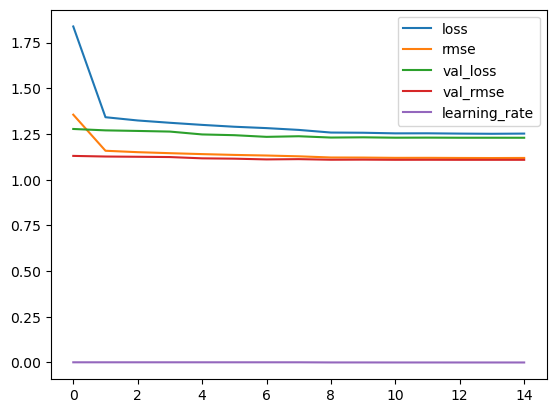

In [20]:
losse.plot()